# Ground plane detection (single image)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from depth_map import createMap2

## Make disparity map

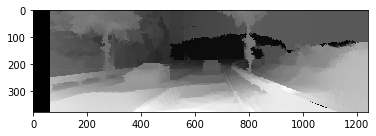

In [2]:
path_to_kitti = "KITTI/data_scene_flow/testing/"
d = createMap2(path_to_kitti,'000183_11.png')
plt.imshow(d, 'gray');
plt.imsave("temp.png",d) # save for later

## Create Road Mask

In [3]:
OFFSET = 60
CURVE = 2000
CUT_OFF = len(d)//3

for i in range(len(d)):
    if i < CUT_OFF:
        d[i] = [-16 for element in d[i]]
    else:
        for j in range(len(d[i])):
            if j != OFFSET and i < int( (float(CURVE)/float(j-OFFSET)) + float(CUT_OFF) ):
                d[i][j] = -16
            elif i < int( (-float(CURVE)/float(j-len(d[i]))) + float(CUT_OFF) ):
                d[i][j] = -16

## Flatten disparity map, add u & v info
Need to revisit

In [4]:
u = np.tile(range(d.shape[1]), d.shape[0])
v = np.repeat(range(d.shape[0]), d.shape[1])
uv_disp = np.array([u,v,d.flatten()]).T

In [5]:
#u,v,disp
uv_disp

array([[   0,    0,  -16],
       [   1,    0,  -16],
       [   2,    0,  -16],
       ...,
       [1238,  375,  -16],
       [1239,  375,  -16],
       [1240,  375,  -16]])

## Remove -16 (no data) pixels

In [6]:
uv_disp_noblanks = uv_disp[uv_disp[:,2]!=-16]
uv_disp_noblanks

array([[   0,  126,    0],
       [   1,  126,    0],
       [   2,  126,    0],
       ...,
       [1231,  375,  196],
       [1232,  375,  196],
       [1233,  375,  196]])

In [7]:
from sklearn.linear_model import RANSACRegressor

In [8]:
u = uv_disp_noblanks[:,0].reshape(-1, 1)
v = uv_disp_noblanks[:,1].reshape(-1, 1)
d = uv_disp_noblanks[:,2]

## Plot

### U (horizontal scan)

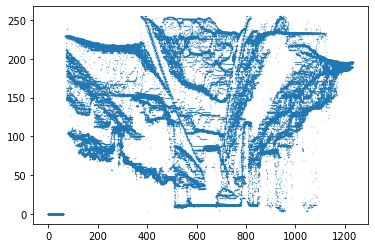

In [9]:
plt.scatter(x=u,y=d, s=0.01);

### V (vertical scan)

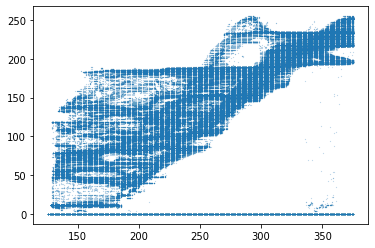

In [10]:
plt.scatter(x=v,y=d, s=0.01);

## Fit line to u, disp and v, disp

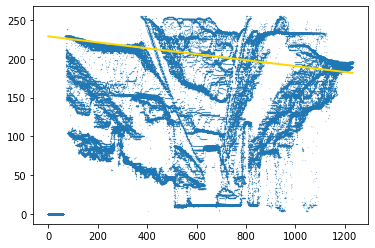

In [11]:
ransac_u = RANSACRegressor()
ransac_u.fit(u,d)
line_u = np.arange(u.min(), u.max())[:, np.newaxis]
line_du = ransac_u.predict(line_u)
plt.scatter(x=u,y=d,s=0.01)
plt.plot(line_u, line_du, color='gold',linewidth=2,label="Ransac regressor");


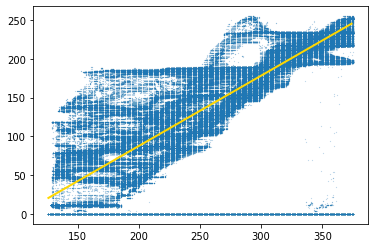

In [12]:
ransac_v = RANSACRegressor()
ransac_v.fit(v,d)
line_v = np.arange(v.min(), v.max())[:, np.newaxis]
line_dv = ransac_v.predict(line_v)
plt.scatter(x=v,y=d,s=0.01)
plt.plot(line_v, line_dv, color='gold',linewidth=2,label="Ransac regressor");

# Check each pixel to see if it fits

In [ ]:
from PIL import Image
img = Image.open("temp.png")

for i,disp in enumerate(d):
    x = line_u[u[i]-line_u[0]-1]-line_u[0]-1
    y = line_v[v[i]-line_v[0]-1]-line_v[0]-1
    #if disp <= line_du[x] and disp <= line_dv[y]:
    if disp <= line_dv[y]:
        img.putpixel((u[i][0],v[i][0]), (255,0,0))
    else:
        img.putpixel((u[i][0],v[i][0]), (0,255,0))
    
img.show();